In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
%matplotlib notebook
import timeit
start_time=timeit.default_timer()

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './write/pmbc3k.h5ad'

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.0.4 anndata==0.6.1 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
untreated = sc.read(path + 'matrix.mtx', cache=True).T  # transpose the data
untreated.var_names = pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
untreated.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
print(untreated.shape)

... reading from cache file ./cache/home-ehamilton-ProjectSummer2018-GRCh38-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
(6617, 33694)


In [3]:
untreated.var_names_make_unique()

In [4]:
sc.pp.filter_cells(untreated, min_genes=200)
sc.pp.filter_genes(untreated, min_cells=3)

In [5]:
mito_genes = [name for name in untreated.var_names if name.startswith('MT-')]
untreated.obs['percent_mito']=np.sum( untreated[:, mito_genes].X, axis=1).A1 / np.sum(untreated.X, axis=1).A1
untreated.obs['n_counts']= untreated.X.sum(axis=1).A1

/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ehamilton/miniconda3/envs/singlecellanalysis/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


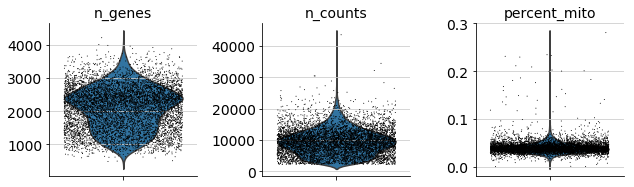

In [6]:
sc.pl.violin(untreated, ['n_genes','n_counts','percent_mito'], jitter=0.4, multi_panel=True)

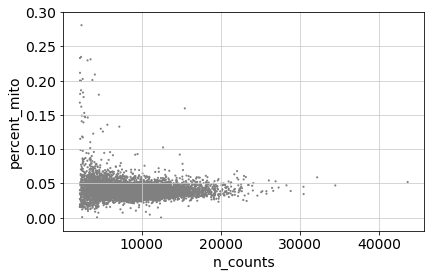

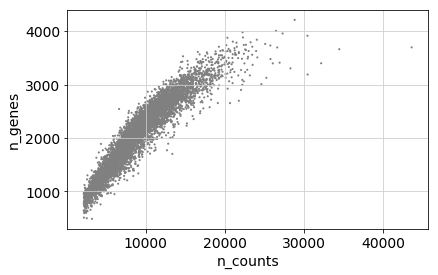

In [7]:
sc.pl.scatter(untreated, x='n_counts',y='percent_mito')
sc.pl.scatter(untreated, x='n_counts',y='n_genes')

In [8]:
untreated = untreated[untreated.obs['n_genes'] < 4000, :]
untreated = untreated[untreated.obs['percent_mito'] < 0.1, :]
print(untreated.shape)

(6578, 15740)


In [9]:
untreated.raw = sc.pp.log1p(untreated, copy=True)

In [10]:
print(untreated.raw)

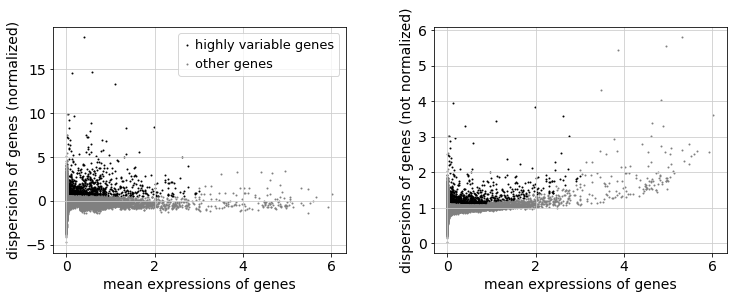

In [11]:
sc.pp.normalize_per_cell(untreated, counts_per_cell_after=20000)
filter_result = sc.pp.filter_genes_dispersion(untreated.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [12]:
untreated = untreated[:, filter_result.gene_subset]

In [13]:
print(untreated.X)

  (0, 0)	2.9664788
  (0, 2)	11.865915
  (0, 4)	2.9664788
  (0, 7)	2.9664788
  (0, 16)	2.9664788
  (0, 19)	2.9664788
  (0, 23)	2.9664788
  (0, 24)	8.899437
  (0, 28)	2.9664788
  (0, 34)	2.9664788
  (0, 35)	20.765352
  (0, 37)	2.9664788
  (0, 38)	2.9664788
  (0, 41)	2.9664788
  (0, 54)	8.899437
  (0, 73)	2.9664788
  (0, 94)	2.9664788
  (0, 102)	2.9664788
  (0, 109)	2.9664788
  (0, 120)	5.9329576
  (0, 136)	2.9664788
  (0, 137)	2.9664788
  (0, 139)	2.9664788
  (0, 142)	5.9329576
  (0, 144)	2.9664788
  :	:
  (6577, 1678)	2.531325
  (6577, 1692)	17.719276
  (6577, 1715)	7.593975
  (6577, 1716)	2.531325
  (6577, 1719)	2.531325
  (6577, 1732)	2.531325
  (6577, 1736)	2.531325
  (6577, 1737)	12.656626
  (6577, 1743)	5.06265
  (6577, 1744)	2.531325
  (6577, 1755)	2.531325
  (6577, 1757)	15.18795
  (6577, 1759)	5.06265
  (6577, 1773)	15.18795
  (6577, 1774)	2.531325
  (6577, 1789)	12.656626
  (6577, 1791)	17.719276
  (6577, 1799)	5.06265
  (6577, 1805)	2.531325
  (6577, 1817)	2.531325
  (6577, 18

In [14]:
sc.pp.log1p(untreated)

In [15]:
sc.pp.scale(untreated, max_value=10)

In [16]:
untreated.write(results_file)

In [17]:
sc.tl.pca(untreated)

In [18]:
untreated.obsm['X_pca'].shape

(6578, 50)

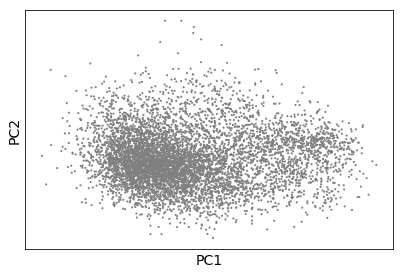

In [19]:
sc.pl.pca_scatter(untreated)

In [20]:
from sklearn.cluster import Birch
import numpy as np

In [21]:
brc = Birch(branching_factor=50, n_clusters=5, threshold=0.5, 
            compute_labels=True)

In [22]:
brc.fit(untreated.X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=5,
   threshold=0.5)

In [23]:
brc.predict(untreated.X)

array([0, 0, 3, ..., 4, 1, 4])

In [24]:
print(brc.predict(untreated.X))

[0 0 3 ... 4 1 4]


In [25]:
df = pd.DataFrame(brc.predict(untreated.X))
df.columns=['Birch']
df

,Birch
0,0
1,0
2,3
3,3
4,4
5,4
6,3
7,4
8,2
9,4


In [26]:
icantbelievethatworked = pd.merge(untreated.obs, untreated.obs)

In [27]:
W = pd.concat([icantbelievethatworked, df], axis=1, join='inner')
W

,n_genes,percent_mito,n_counts,Birch
0,1359,0.040047,6742.0,0
1,1915,0.045527,8193.0,0
2,1608,0.055618,6221.0,3
3,1025,0.026316,3382.0,3
4,2104,0.023848,7506.0,4
5,3067,0.042044,15793.0,4
6,2490,0.046813,10040.0,3
7,3206,0.036937,17029.0,4
8,767,0.027322,2196.0,2
9,2596,0.040273,12887.0,4


In [97]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/'
outfile = outpath + 'BirchDownsizedCellListNEW.csv'
W.to_csv(outfile, sep='\t')

In [28]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
V = pd.read_csv(path + 'OBSFiveClusterLouvain.csv', sep='\t')

In [29]:
B = pd.merge(V, W, on=['n_counts','n_genes'])
B

,index,n_genes,percent_mito_x,n_counts,louvain,percent_mito_y,Birch
0,AAACCTGCAAGTAATG-1,1359,0.040047,6742.0,0,0.040047,0
1,AAACCTGCAAGTCTGT-1,1915,0.045527,8193.0,0,0.045527,0
2,AAACCTGCATCCTAGA-1,1608,0.055618,6221.0,0,0.055618,3
3,AAACCTGGTCCGCTGA-1,1025,0.026316,3382.0,3,0.026316,3
4,AAACCTGGTCGAGATG-1,2104,0.023848,7506.0,1,0.023848,4
5,AAACCTGGTCGCGGTT-1,3067,0.042044,15793.0,1,0.042044,4
6,AAACCTGGTTACGTCA-1,2490,0.046813,10040.0,3,0.046813,3
7,AAACCTGTCACTCCTG-1,3206,0.036937,17029.0,1,0.036937,4
8,AAACCTGTCCAGGGCT-1,767,0.027322,2196.0,0,0.027322,2
9,AAACCTGTCGGACAAG-1,2596,0.040273,12887.0,1,0.040273,4


In [30]:
from sklearn import metrics

metrics.adjusted_rand_score(B['louvain'], B['Birch'])  

0.10669937102804143

In [31]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(B['louvain'], B['Birch'])

0.2657664878064658

In [32]:
B.groupby(["louvain", "Birch"]).size()

louvain  Birch
0        0         536
         1         884
         2         784
         3          33
         4        2015
1        0         148
         1          80
         2         127
         3           8
         4         974
2        0         588
         1           1
         2           8
         3           2
         4          39
3        0          10
         1           8
         2          17
         3         267
         4          12
4        3          45
dtype: int64

In [33]:
import seaborn as sns
import pandas as pd
import numpy as np

In [34]:
x = ['Louvain','L1','L2','L3','L4','L5']
y = ['Birch','B2','B5','B1','B3','B4']

In [35]:
intensity = [
    [0.2079, 0.0598, 0.0016, 0.0255, 0.0000],
    [0.4739, 0.7285, 0.0611, 0.0382, 0.0000],
    [0.1260, 0.1107, 0.9216, 0.0318, 0.0000],
    [0.1844, 0.0950, 0.0125, 0.0541, 0.0000],
    [0.0078, 0.0060, 0.0031, 0.8503, 1.0000]
]


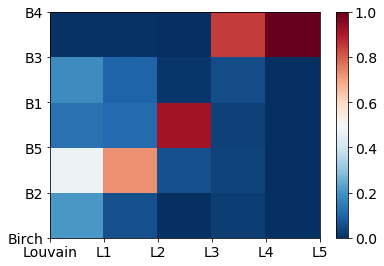

In [36]:
x, y = np.meshgrid(x, y)

intensity = np.array(intensity)

plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()


In [37]:
path = '/home/ehamilton/ProjectSummer2018/GRCh38/'
Q = pd.read_csv(path + 'KMeanDownsizedCellListNEW.csv', sep='\t')

In [38]:
M = pd.merge(B, Q, on=['n_counts','n_genes'])

In [39]:
metrics.adjusted_rand_score(M['KMean'], M['Birch'])  

0.31532706191970844

In [40]:
normalized_mutual_info_score(M['KMean'], M['Birch'])

0.345488449536751

In [41]:
M.groupby(["KMean", "Birch"]).size()

KMean  Birch
0      0         144
       1         244
       2          26
       3         143
       4        1608
1      0          81
       1         101
       2          28
       3          67
       4         926
2      0          38
       1          15
       2         789
       3          15
       4         109
3      0          95
       1         583
       2          27
       3         101
       4         234
4      0         926
       1          30
       2          76
       3          29
       4         167
dtype: int64

In [42]:
x = ['KMeans','K1','K2','K3','K4','K5']
y = ['Birch','B4','B5','B3','B2','B1']

In [43]:
intensity = [
    [0.0661, 0.0557, 0.0155, 0.0971, 0.0236],
    [0.7427, 0.7697, 0.1128, 0.2250, 0.1360],
    [0.0120, 0.0233, 0.8168, 0.0260, 0.0619],
    [0.1127, 0.0840, 0.0155, 0.5606, 0.0244],
    [0.0665, 0.0673, 0.0393, 0.0913, 0.7541]
]

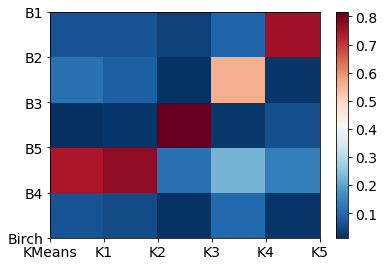

In [44]:
x, y = np.meshgrid(x, y)

intensity = np.array(intensity)

plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()

In [45]:
import random
x=random.sample(range(6577),3000)

In [46]:
untreated_subset3K = untreated[x, :]

In [47]:
untreated_subset3K.var_names_make_unique()

In [48]:
sc.tl.pca(untreated_subset3K)

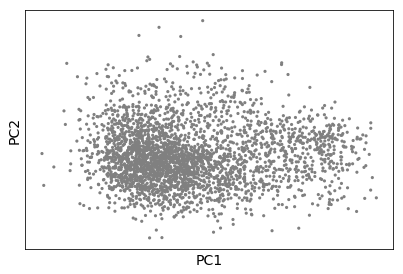

In [49]:
sc.pl.pca_scatter(untreated_subset3K)

In [50]:
brc3K = Birch(branching_factor=50, n_clusters=5, threshold=0.5, 
            compute_labels=True)

In [51]:
brc3K.fit(untreated_subset3K.X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=5,
   threshold=0.5)

In [52]:
brc3K.predict(untreated_subset3K.X)

array([3, 2, 1, ..., 2, 1, 0])

In [53]:
print(brc3K.predict(untreated_subset3K.X))

[3 2 1 ... 2 1 0]


In [54]:
df3K = pd.DataFrame(brc3K.predict(untreated_subset3K.X))
df3K.columns=['Birch']
df3K

,Birch
0,3
1,2
2,1
3,4
4,0
5,1
6,3
7,0
8,0
9,0


In [55]:
icantbelievethatworked3K = pd.merge(untreated_subset3K.obs, untreated_subset3K.obs)

In [56]:
Birch3K = pd.concat([icantbelievethatworked3K, df3K], axis=1, join='inner')

In [57]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 3000/'
outfile = outpath + 'BirchDownsizedCellList3K_5.csv'
Birch3K.to_csv(outfile, sep='\t')

In [58]:
x=random.sample(range(6577),1000)

In [59]:
untreated_subset1K = untreated[x, :]

In [60]:
untreated_subset1K.var_names_make_unique()

In [61]:
sc.tl.pca(untreated_subset1K)

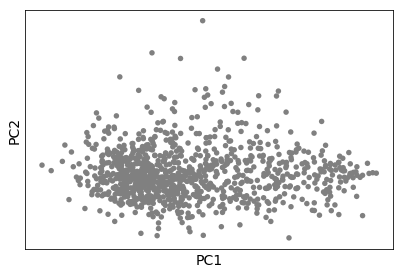

In [62]:
sc.pl.pca_scatter(untreated_subset1K)

In [63]:
brc1K = Birch(branching_factor=50, n_clusters=5, threshold=0.5, 
            compute_labels=True)

In [64]:
brc1K.fit(untreated_subset1K.X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=5,
   threshold=0.5)

In [65]:
brc1K.predict(untreated_subset1K.X)

array([0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 3, 2, 0, 2, 3, 2, 1, 2, 3, 2, 2, 1,
       2, 0, 3, 2, 1, 3, 1, 2, 2, 3, 1, 2, 2, 3, 2, 0, 1, 1, 2, 2, 3, 2,
       2, 2, 2, 3, 2, 0, 2, 2, 4, 2, 3, 2, 3, 3, 1, 2, 0, 1, 2, 2, 2, 2,
       4, 0, 2, 4, 0, 2, 2, 1, 0, 2, 2, 2, 2, 4, 3, 2, 2, 2, 0, 2, 3, 0,
       4, 3, 2, 2, 4, 0, 2, 2, 3, 2, 2, 0, 1, 1, 1, 4, 1, 0, 3, 0, 2, 3,
       2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
       3, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 1, 2, 2, 4, 2,
       1, 0, 2, 0, 1, 1, 3, 1, 4, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 3, 2, 3, 2, 4, 2, 2, 3, 2, 1, 1, 2, 3, 2, 2, 2, 1,
       2, 0, 2, 3, 3, 2, 3, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 3, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 1, 4, 2, 2, 3, 2, 2,
       0, 0, 4, 1, 2, 4, 2, 1, 2, 3, 2, 2, 2, 0, 2, 4, 2, 1, 2, 4, 2, 0,
       1, 2, 2, 2, 2, 2, 2, 1, 0, 4, 2, 3, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1,
       1, 2, 4, 0, 1, 3, 2, 2, 2, 1, 1, 3, 2, 2, 1,

In [66]:
print(brc1K.predict(untreated_subset1K.X))

[0 2 2 1 2 1 2 2 2 2 3 2 0 2 3 2 1 2 3 2 2 1 2 0 3 2 1 3 1 2 2 3 1 2 2 3 2
 0 1 1 2 2 3 2 2 2 2 3 2 0 2 2 4 2 3 2 3 3 1 2 0 1 2 2 2 2 4 0 2 4 0 2 2 1
 0 2 2 2 2 4 3 2 2 2 0 2 3 0 4 3 2 2 4 0 2 2 3 2 2 0 1 1 1 4 1 0 3 0 2 3 2
 2 2 1 0 2 2 0 2 2 2 2 2 2 1 1 2 0 2 2 2 1 3 0 0 2 2 1 2 2 2 2 0 2 2 3 2 2
 2 1 2 2 4 2 1 0 2 0 1 1 3 1 4 1 1 2 2 2 2 2 3 2 2 2 1 2 1 2 2 2 2 3 2 3 2
 4 2 2 3 2 1 1 2 3 2 2 2 1 2 0 2 3 3 2 3 0 2 2 0 2 1 2 2 2 2 1 3 2 0 2 2 0
 2 2 2 2 2 2 2 3 1 1 2 2 2 1 4 2 2 3 2 2 0 0 4 1 2 4 2 1 2 3 2 2 2 0 2 4 2
 1 2 4 2 0 1 2 2 2 2 2 2 1 0 4 2 3 2 1 1 2 2 1 2 2 2 1 1 2 4 0 1 3 2 2 2 1
 1 3 2 2 1 2 2 3 0 4 0 2 2 4 2 0 2 4 2 2 2 2 2 2 2 1 1 3 2 2 0 2 1 2 1 2 3
 2 4 2 0 0 1 2 1 2 3 0 0 0 2 2 2 2 2 4 4 2 2 4 1 2 2 2 3 2 1 0 3 2 0 2 1 2
 1 1 2 2 2 2 2 2 1 2 0 0 4 2 2 2 2 2 2 2 0 3 2 2 2 1 1 2 2 3 0 2 2 0 2 2 1
 3 4 0 0 0 2 0 2 2 2 2 2 2 0 2 3 2 1 2 0 3 3 2 1 1 2 2 2 0 4 3 1 1 2 0 3 2
 2 2 2 2 3 2 2 2 0 0 2 4 1 2 2 3 0 0 2 2 2 2 1 2 1 2 2 4 2 2 1 2 1 2 1 1 2
 1 2 2 0 2 2 4 1 0 2 2 2 

In [67]:
df1K = pd.DataFrame(brc1K.predict(untreated_subset1K.X))
df1K.columns=['Birch']
df1K

,Birch
0,0
1,2
2,2
3,1
4,2
5,1
6,2
7,2
8,2
9,2


In [68]:
icantbelievethatworked1K = pd.merge(untreated_subset1K.obs, untreated_subset1K.obs)

In [69]:
Birch1K = pd.concat([icantbelievethatworked1K, df1K], axis=1, join='inner')

In [70]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 1000/'
outfile = outpath + 'BirchDownsizedCellList1K_5.csv'
Birch1K.to_csv(outfile, sep='\t')

In [71]:
x=random.sample(range(6577),500)

In [72]:
untreated_subset500 = untreated[x, :]

In [73]:
untreated_subset500.var_names_make_unique()

In [74]:
sc.tl.pca(untreated_subset500)

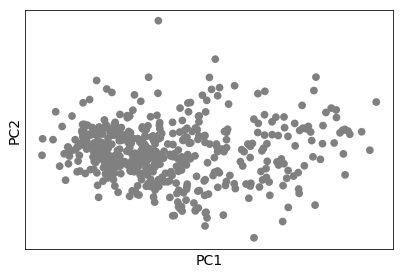

In [75]:
sc.pl.pca_scatter(untreated_subset500)

In [76]:
brc500 = Birch(branching_factor=50, n_clusters=5, threshold=0.5, 
            compute_labels=True)

In [77]:
brc500.fit(untreated_subset500.X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=5,
   threshold=0.5)

In [78]:
brc500.predict(untreated_subset500.X)

array([1, 0, 2, 0, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 2, 0, 0, 2, 0, 0, 2,
       0, 2, 1, 1, 3, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 4, 1, 3, 0, 0, 0, 1, 3, 2, 1, 4, 2, 0, 1, 0, 4, 4, 0,
       2, 2, 2, 3, 0, 4, 0, 4, 0, 0, 2, 4, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 2, 3, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 4, 4, 0, 4,
       0, 4, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 4, 2, 0, 0, 0, 1, 1, 4,
       3, 0, 0, 4, 0, 4, 1, 0, 0, 4, 0, 2, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0,
       4, 4, 2, 0, 2, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2,
       0, 0, 0, 2, 1, 4, 2, 0, 4, 4, 0, 2, 0, 0, 0, 2, 1, 3, 1, 0, 0, 4,
       0, 2, 0, 0, 4, 0, 0, 2, 2, 0, 0, 1, 1, 4, 0, 0, 0, 1, 0, 2, 0, 0,
       0, 2, 0, 1, 2, 0, 2, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 0,

In [79]:
print(brc500.predict(untreated_subset500.X))

[1 0 2 0 0 0 2 0 0 3 2 0 0 0 0 0 1 2 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 4 3 4 0
 2 0 0 2 0 0 2 0 2 1 1 3 0 0 0 0 2 2 0 0 1 0 0 3 0 0 0 0 0 0 2 0 0 4 1 3 0
 0 0 1 3 2 1 4 2 0 1 0 4 4 0 2 2 2 3 0 4 0 4 0 0 2 4 0 2 0 0 0 2 2 0 0 0 0
 0 0 2 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 3 0 0 0 2 3 2 0 0 2 0 0 2 0 0 0 0 0 1
 1 0 4 4 0 4 0 4 2 0 0 0 0 0 0 1 0 1 0 1 4 2 0 0 0 1 1 4 3 0 0 4 0 4 1 0 0
 4 0 2 0 2 3 0 0 2 0 0 0 0 4 4 2 0 2 0 0 0 3 1 0 0 0 0 0 2 0 0 0 1 0 2 0 0
 0 2 1 4 2 0 4 4 0 2 0 0 0 2 1 3 1 0 0 4 0 2 0 0 4 0 0 2 2 0 0 1 1 4 0 0 0
 1 0 2 0 0 0 2 0 1 2 0 2 4 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 2 0 0
 1 2 0 0 0 2 1 1 4 0 1 0 2 0 1 3 0 0 0 0 2 2 0 0 1 0 0 0 0 4 0 0 0 4 3 0 0
 0 2 2 1 2 3 2 4 0 2 0 0 0 0 0 0 0 0 0 4 0 1 0 0 2 2 0 0 0 2 0 4 2 0 0 2 0
 1 0 0 0 0 0 2 2 2 0 0 2 4 1 2 2 2 0 2 0 1 0 0 2 0 0 0 0 3 0 0 0 0 0 0 2 0
 0 0 1 1 1 0 2 0 0 0 0 0 0 2 0 0 1 2 2 0 0 0 0 0 1 0 0 0 0 0 2 2 1 0 0 0 2
 0 1 0 2 1 2 2 0 1 0 0 4 0 0 2 0 4 1 0 0 0 0 0 4 2 2 1 1 0 3 0 0 2 4 0 0 0
 3 0 0 2 0 2 0 0 2 0 0 0 

In [80]:
df500 = pd.DataFrame(brc500.predict(untreated_subset500.X))
df500.columns=['Birch']
df500

,Birch
0,1
1,0
2,2
3,0
4,0
5,0
6,2
7,0
8,0
9,3


In [81]:
icantbelievethatworked500 = pd.merge(untreated_subset500.obs, untreated_subset500.obs)

In [82]:
Birch500 = pd.concat([icantbelievethatworked500, df500], axis=1, join='inner')

In [83]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 500/'
outfile = outpath + 'BirchDownsizedCellList500_5.csv'
Birch500.to_csv(outfile, sep='\t')

In [84]:
x=random.sample(range(6577),300)

In [85]:
untreated_subset300 = untreated[x, :]

In [86]:
untreated_subset300.var_names_make_unique()

In [87]:
sc.tl.pca(untreated_subset300)

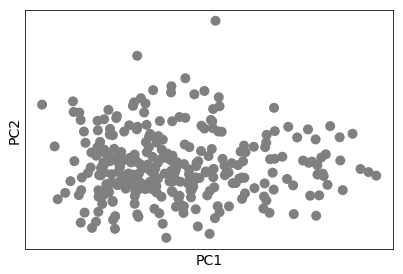

In [88]:
sc.pl.pca_scatter(untreated_subset300)

In [89]:
brc300 = Birch(branching_factor=50, n_clusters=5, threshold=0.5, 
            compute_labels=True)

In [90]:
brc300.fit(untreated_subset300.X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=5,
   threshold=0.5)

In [91]:
brc300.predict(untreated_subset300.X)

array([2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 4, 0, 1, 0, 0, 3, 0, 0, 2,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 0, 0,
       1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0])

In [92]:
print(brc300.predict(untreated_subset300.X))

[2 0 1 0 0 0 1 0 2 0 1 1 0 2 1 1 0 0 1 0 1 0 0 0 0 2 0 0 0 0 0 0 1 0 0 2 2
 2 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 2 0 0 0 0 0 1 0
 0 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0
 1 0 0 0 1 0 1 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 0 0
 0 2 0 0 1 0 0 0 2 2 0 0 0 0 0 1 2 0 1 1 0 1 1 1 0 2 2 0 0 0 0 0 0 0 2 0 0
 0 0 1 2 0 1 1 0 0 0 0 0 0 2 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 2 2 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 1 0 4 0 1 0
 0 3 0 0 2 0 1 0 0 0 0 1 0 0 2 0 0 1 0 2 2 0 0 0 2 0 0 1 0 0 2 1 1 1 0 0 0
 0 0 1 0]


In [93]:
df300 = pd.DataFrame(brc300.predict(untreated_subset300.X))
df300.columns=['Birch']
df300

,Birch
0,2
1,0
2,1
3,0
4,0
5,0
6,1
7,0
8,2
9,0


In [94]:
icantbelievethatworked300 = pd.merge(untreated_subset300.obs, untreated_subset300.obs)

In [95]:
Birch300 = pd.concat([icantbelievethatworked300, df300], axis=1, join='inner')

In [96]:
outpath= '/home/ehamilton/ProjectSummer2018/GRCh38/All downsizing files for week 7-16/Subset 300/'
outfile = outpath + 'BirchDownsizedCellList300_5.csv'
Birch300.to_csv(outfile, sep='\t')